#本文件請在Colab上面執行


## 權重與模型下載

In [ ]:
#Linux的wget指令，直接下載雲端檔案
#模型下載

!wget --no-check-certificate "https://drive.google.com/uc?export=download&id=1D13A7yw2QXuFDBhqWNF8yRq3GVFIfzsG" -O genre_model.json
# 權重下載
!wget --no-check-certificate "https://drive.google.com/uc?export=download&id=1MfRMwswBC53-V5UO06sbwk1pyWAHT85d" -O genre_model_weights.h5

#載入模型
import keras
from keras.models import model_from_json
from keras.optimizers import SGD,Adam
model = model_from_json(open('genre_model.json').read())

model.load_weights('genre_model_weights.h5')

model.compile(loss='binary_crossentropy', optimizer=Adam())

--2019-09-18 06:45:17--  https://drive.google.com/uc?export=download&id=1D13A7yw2QXuFDBhqWNF8yRq3GVFIfzsG
Resolving drive.google.com (drive.google.com)... 74.125.20.138, 74.125.20.113, 74.125.20.102, ...
Connecting to drive.google.com (drive.google.com)|74.125.20.138|:443... connected.
HTTP request sent, awaiting response... 302 Moved Temporarily
Location: https://doc-0k-6c-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/737s2t33gkppt3s2locmkua8cdiv64hc/1568786400000/10924391630315724863/*/1D13A7yw2QXuFDBhqWNF8yRq3GVFIfzsG?e=download [following]
--2019-09-18 06:45:17--  https://doc-0k-6c-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/737s2t33gkppt3s2locmkua8cdiv64hc/1568786400000/10924391630315724863/*/1D13A7yw2QXuFDBhqWNF8yRq3GVFIfzsG?e=download
Resolving doc-0k-6c-docs.googleusercontent.com (doc-0k-6c-docs.googleusercontent.com)... 74.125.142.132, 2607:f8b0:400e:c08::84
Connecting to doc-0k-6c-docs.googleusercontent.com (doc-0k-6c-

Using TensorFlow backend.







Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


## 上傳檔案路徑設定

In [ ]:
import os
os.mkdir('upload')
os.chdir('upload')
os.getcwd() #查看目前路徑

'/content/upload'

## 檔案預處理function

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
import librosa
import pandas as pd
import numpy as np

#音訊特徵值轉換
def to_melspectrogram(songs, n_fft = 1024, hop_length = 512):
    # Transformation function
    melspec = lambda x: librosa.feature.melspectrogram(x, n_fft = n_fft,hop_length = hop_length)[:,:,np.newaxis]

    # map transformation of input songs to melspectrogram using log-scale
    tsongs = map(melspec, songs)
    return np.array(list(tsongs))
  
#歌曲切割
def splitsongs(X, window = 0.1, overlap = 0.5):
    # Empty lists to hold our results
    temp_X = []
    #temp_y = []

    # Get the input song array size
    xshape = X.shape[0]
    chunk = int(xshape*window)
    offset = int(chunk*(1.-overlap))
    
    # Split the song and create new ones on windows
    spsong = [X[i:i+chunk] for i in range(0, xshape - chunk + offset, offset)]
    for s in spsong:
        temp_X.append(s)
        #temp_y.append(y)

    return np.array(temp_X)
  
def read_data(f_name,song_samples, spec_format, debug = True):
  arr_specs = []
  
  # Debug process
  for f in(f_name):
    f = str(f)
    if debug:
      print("Reading file: {}".format(f))
    #check data length
    signal, sr = librosa.load(f)
    while len(signal)< song_samples:
      print('audio is too short.')
      break
    else:
      signal = signal[:song_samples]
      signals = splitsongs(signal)
      specs = spec_format(signals)
      #save files
      arr_specs.extend(specs)
      print('loadding is done')

  return np.array(arr_specs)


#分類轉換
def one_hot(pre):
  p_o = []
  for i in pre:
    one_hot = []
    for j in i:
      m = max(i)
      if j == m:
        j = 1
      else:
        j = 0
      one_hot.append(j)
      one_hot = list(one_hot)
    p_o.append(one_hot.index(1))
  
  return list(p_o)

#模型預測結果顯示
def predict_result(file_list,song_samples):
  genres = {0:"Children's",1:'Holiday',2:'Classical',3:'Cinematic',4:'Dance & Electronic',5:'Pop',6:'R&B & Soul',7:'Jazz & Blues',
          8:'Ambient',9:'Hip Hop & Rap',10:'Rock',11:'Alternative & Punk',12:'Country & Folk',13:'Reggae'}
  X = read_data(f_list,song_samples,to_melspectrogram,debug=True)
  predict_list = model.predict(X, batch_size=None, verbose=0, steps=None)
  predict_list = one_hot(predict_list)
  import pandas as pd
  r = pd.value_counts(predict_list)
  r = pd.DataFrame(r)
  gen = []
  for i in genres.keys():
    if sum(r.index == i) == 1:
        name = genres[i]
        gen.append(name)
  r.index = gen
  return pd.DataFrame(r), print('Your song Classify Result is : ',str(list(r[0].index[np.array(r[0]) == max(list(r[0]))]))),print(r),plt.title('The small sample classify result in the song'),plt.bar(r.index,r[0],alpha = 0.5)
        
  

#檔案上傳

In [ ]:
from google.colab import files
uploaded = files.upload()

Saving 20180912 011645-FD124619.m4a to 20180912 011645-FD124619.m4a


# 實際使用

Reading file: 20180912 011645-FD124619.m4a
loadding is done
Your song Classify Result is :  ['Cinematic']
                     0
Cinematic           17
Dance & Electronic   2


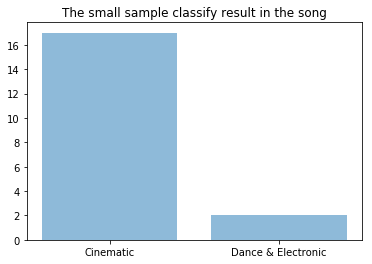

In [ ]:
f_list = os.listdir()
song_samples = 660000
AA = predict_result(f_list,song_samples)